In [ ]:
# Connecting to google drive

from google.colab import drive


drive.mount('/content/drive')

%cd /content/drive/My Drive/Clients Projects/Uncompleted/Thriters Sales Project

Mounted at /content/drive
/content/drive/My Drive/Clients Projects/Uncompleted/Thriters Sales Project


### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
import joblib
import warnings
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score, r2_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Settings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})


In [ ]:
# Check head

df = pd.read_csv('data.csv')
df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Order ID,405-8078784-5731545,171-9198151-1101146,404-0687676-7273146,403-9615377-8133951,407-1069790-7240320
Date,04-30-22,04-30-22,04-30-22,04-30-22,04-30-22
Status,Cancelled,Shipped - Delivered to Buyer,Shipped,Cancelled,Shipped
Fulfilment,Merchant,Merchant,Amazon,Merchant,Amazon
Sales Channel,Amazon.in,Amazon.in,Amazon.in,Amazon.in,Amazon.in
ship-service-level,Standard,Standard,Expedited,Standard,Expedited
Style,SET389,JNE3781,JNE3371,J0341,JNE3671
SKU,SET389-KR-NP-S,JNE3781-KR-XXXL,JNE3371-KR-XL,J0341-DR-L,JNE3671-TU-XXXL
Category,Set,kurta,kurta,Western Dress,Top


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

In [ ]:
df.describe()

,index,Qty,Amount,ship-postal-code
count,128975.000000,128975.000000,121180.000000,128942.000000
mean,64487.000000,0.904431,648.561465,463966.236509
std,37232.019822,0.313354,281.211687,191476.764941
min,0.000000,0.000000,0.000000,110001.000000
25%,32243.500000,1.000000,449.000000,382421.000000
50%,64487.000000,1.000000,605.000000,500033.000000
75%,96730.500000,1.000000,788.000000,600024.000000
max,128974.000000,15.000000,5584.000000,989898.000000


### Clean and prepare the dataframe for analysis.

In [ ]:
def clean_dataframe(df):
    """
    Cleans and prepares the dataframe for analysis.

    Parameters:
    df (DataFrame): The original dataframe.

    Returns:
    DataFrame: The cleaned dataframe.
    """
    # Clean column names
    df.columns = df.columns.str.lower().str.replace(" ", "").str.replace("-", "")

    # Drop redundant columns
    redundant_cols = [
        "index", "date", "fulfilledby", "currency",
        "unnamed:22", "promotionids", "courierstatus", "shipcountry"
    ]
    df.drop(columns=redundant_cols, inplace=True)

    # Fill missing values
    df['shipstate'].fillna('unknown', inplace=True)
    df['shipcity'].fillna('unknown', inplace=True)
    df['shippostalcode'].fillna(0, inplace=True)

    # Convert postalcode to integer type, then to object
    df['shippostalcode'] = df['shippostalcode'].astype(int).astype(str)

    # Standardize shipstate values
    state_corrections = {
        "PONDICHERRY": "PUDUCHERRY", "RAJSHTHAN": "RAJASTHAN",
        "RAJSTHAN": "RAJASTHAN", "RJ": "RAJASTHAN", "PB": "PUNJAB",
        "PUNJAB/MOHALI/ZIRAKPUR": "PUNJAB", "ORISSA": "ODISHA",
        "DELHI": "NEW DELHI", "NL": "UNKNOWN", "APO": "UNKNOWN",
        "AR": "UNKNOWN"
    }
    df['shipstate'] = df['shipstate'].str.upper().replace(state_corrections)

    # Drop duplicate rows
    df.drop_duplicates(inplace=True)

    return df


In [ ]:
df = clean_dataframe(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128969 entries, 0 to 128974
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   orderid           128969 non-null  object 
 1   status            128969 non-null  object 
 2   fulfilment        128969 non-null  object 
 3   saleschannel      128969 non-null  object 
 4   shipservicelevel  128969 non-null  object 
 5   style             128969 non-null  object 
 6   sku               128969 non-null  object 
 7   category          128969 non-null  object 
 8   size              128969 non-null  object 
 9   asin              128969 non-null  object 
 10  qty               128969 non-null  int64  
 11  amount            121177 non-null  float64
 12  shipcity          128969 non-null  object 
 13  shipstate         128969 non-null  object 
 14  shippostalcode    128969 non-null  object 
 15  b2b               128969 non-null  bool   
dtypes: bool(1), float64(

In [ ]:
def analyze_order_repetitions(df):
    """
    Analyzes the repetition of order IDs in a dataframe.

    Parameters:
    df (DataFrame): The dataframe containing order data.

    Returns:
    tuple: Counts of unique repeated order IDs, total rows of repeated orders, and rows of non-repeated orders.
    """
    # Identifying rows with repeated and non-repeated order IDs
    repeated_order_filter = df["orderid"].duplicated(keep=False)
    repeated_orders = df[repeated_order_filter]
    non_repeated_orders = df[~repeated_order_filter]

    # Calculating various counts
    count_unique_repeated_orders = repeated_orders["orderid"].nunique()
    count_repeated_order_rows = len(repeated_orders)
    count_non_repeated_order_rows = len(non_repeated_orders)

    return count_unique_repeated_orders, count_repeated_order_rows, count_non_repeated_order_rows

# Usage of the function
unique_repeated_count, repeated_rows_count, non_repeated_rows_count = analyze_order_repetitions(df)

print(f"1. Number of unique order IDs with multiple entries: {unique_repeated_count}\n"
      f"2. Total rows of these order IDs: {repeated_rows_count}\n"
      f"3. Rows with unique, single-entry order IDs: {non_repeated_rows_count}")


1. Number of unique order IDs with multiple entries: 6840
2. Total rows of these order IDs: 15431
3. Rows with unique, single-entry order IDs: 113538


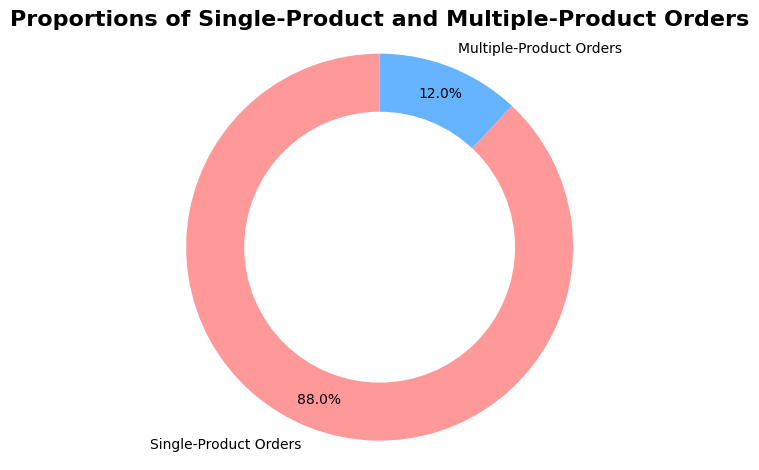

In [ ]:
def plot_order_type_proportions_pie(df):
    """
    Plots a pie chart showing the proportions of single-product and multiple-product orders.

    Parameters:
    df (DataFrame): The dataframe containing order data.
    """
    # Identify repeated and non-repeated order IDs
    is_repeated_order = df["orderid"].duplicated(keep=False)
    order_type_proportions = is_repeated_order.value_counts(normalize=True)

    # Labels for pie chart
    labels = ['Single-Product Orders', 'Multiple-Product Orders']
    sizes = order_type_proportions * 100  # Convert proportions to percentages
    colors = ['#ff9999','#66b3ff']  # Custom colors for the pie chart

    # Pie chart
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=90, pctdistance=0.85)

    # Draw a circle at the center of pie to make it look like a donut
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')

    plt.title("Proportions of Single-Product and Multiple-Product Orders", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Usage of the function
plot_order_type_proportions_pie(df)


### This shows that single product orders are far more, hence more significant, we'll focus on those and drop multiple products

In [ ]:
df = df[df["orderid"].duplicated(keep = False) == False]

df.drop("orderid", axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113538 entries, 0 to 128974
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   status            113538 non-null  object 
 1   fulfilment        113538 non-null  object 
 2   saleschannel      113538 non-null  object 
 3   shipservicelevel  113538 non-null  object 
 4   style             113538 non-null  object 
 5   sku               113538 non-null  object 
 6   category          113538 non-null  object 
 7   size              113538 non-null  object 
 8   asin              113538 non-null  object 
 9   qty               113538 non-null  int64  
 10  amount            106449 non-null  float64
 11  shipcity          113538 non-null  object 
 12  shipstate         113538 non-null  object 
 13  shippostalcode    113538 non-null  object 
 14  b2b               113538 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(12)
memory usage: 13.1+ MB


In [ ]:
def create_rejection_feature(dataframe):
    """
    Creates a 'rejected' column in the dataframe based on the 'status' column,
    indicating whether an order was rejected or not.

    Parameters:
    dataframe (DataFrame): Original dataframe with 'status' column.

    Returns:
    DataFrame: Modified dataframe with 'rejected' column.
    """
    # Define status values that indicate rejection and non-rejection
    rejection_statuses = ['Cancelled', 'Shipped - Returned to Seller', 'Shipped - Rejected by Buyer', 'Shipped - Returning to Seller']
    non_rejection_status = ['Shipped - Delivered to Buyer']

    # Filter dataframe to include only known status values
    known_statuses = rejection_statuses + non_rejection_status
    filtered_df = dataframe[dataframe["status"].isin(known_statuses)]

    # Create 'rejected' column
    filtered_df['rejected'] = filtered_df['status'].isin(rejection_statuses).astype(int)

    # Drop the 'status' column
    final_df = filtered_df.drop(columns=['status'])

    return final_df

# Usage of the function
df = create_rejection_feature(df)


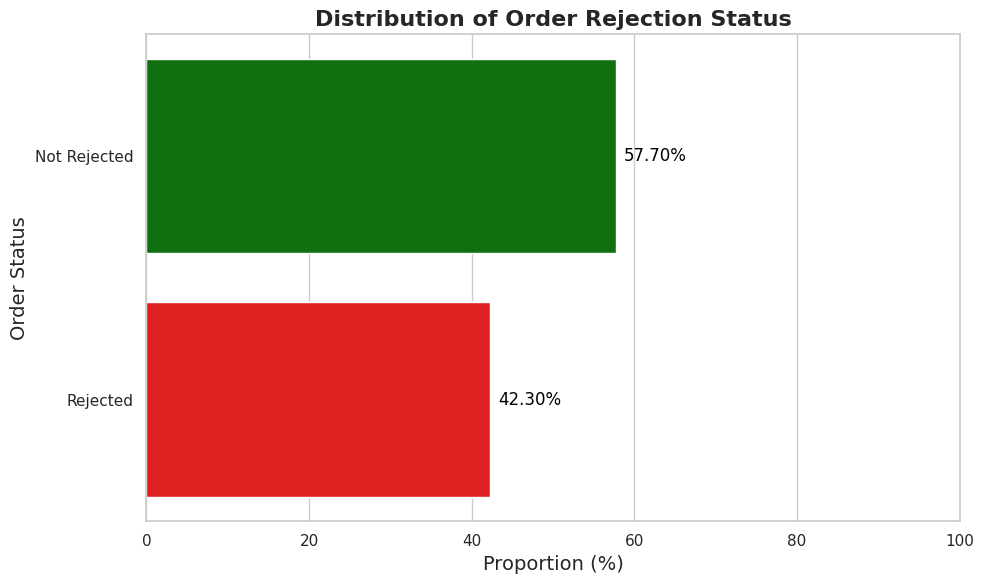

In [ ]:
def plot_rejection_status(df):
    """
    Plots a horizontal bar chart with custom colors showing the proportions of rejected and not-rejected orders.

    Parameters:
    df (DataFrame): The dataframe containing rejection data.
    """
    # Calculate proportion values
    rejection_proportions = df["rejected"].value_counts(normalize=True).sort_index() * 100

    # Prepare data for plotting
    plot_data = pd.DataFrame({'Status': ['Not Rejected', 'Rejected'],
                              'Proportion': rejection_proportions.values,
                              'Color': ['green', 'red']})

    # Seaborn plot settings for aesthetics
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # Creating horizontal bar plot with custom colors
    bar_plot = sns.barplot(x='Proportion', y='Status', data=plot_data, palette=plot_data['Color'])

    # Adding data labels
    for p in bar_plot.patches:
        width = p.get_width()  # get bar length
        bar_plot.text(width + 1,  # set the text at 1 unit right of the bar
                      p.get_y() + p.get_height() / 2,  # get Y coordinate + half of bar height
                      '{:1.2f}%'.format(width),  # format label
                      ha='left', va='center', fontsize=12, color='black')

    # Chart Title and Labels
    plt.title("Distribution of Order Rejection Status", fontsize=16, fontweight='bold')
    plt.xlabel("Proportion (%)", fontsize=14)
    plt.ylabel("Order Status", fontsize=14)
    plt.xlim(0, 100)  # Set x-axis limits for better readability

    plt.tight_layout()
    plt.show()

# Usage of the function
plot_rejection_status(df)


In [ ]:
# Checking for High Cardinality Categorical Features


def drop_high_cardinality_features(dataframe):
    """
    Drops high cardinality features from the dataframe.

    Parameters:
    dataframe (DataFrame): Original dataframe.

    Returns:
    DataFrame: Modified dataframe.
    """
    high_cardinality_columns = ["style", "sku", "shipcity", "shippostalcode", "asin"]
    return dataframe.drop(columns=high_cardinality_columns)

df = drop_high_cardinality_features(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43000 entries, 0 to 128969
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fulfilment        43000 non-null  object 
 1   saleschannel      43000 non-null  object 
 2   shipservicelevel  43000 non-null  object 
 3   category          43000 non-null  object 
 4   size              43000 non-null  object 
 5   qty               43000 non-null  int64  
 6   amount            36034 non-null  float64
 7   shipstate         43000 non-null  object 
 8   b2b               43000 non-null  bool   
 9   rejected          43000 non-null  int64  
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 3.3+ MB


In [ ]:
# Checking Other Features (Non-Object Data Types)

# Display features excluding dtype "object"
df.select_dtypes(exclude="object").info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 43000 entries, 0 to 128969
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   qty       43000 non-null  int64  
 1   amount    36034 non-null  float64
 2   b2b       43000 non-null  bool   
 3   rejected  43000 non-null  int64  
dtypes: bool(1), float64(1), int64(2)
memory usage: 1.4 MB


## Exploratory Analysis

### Univariate Analysis

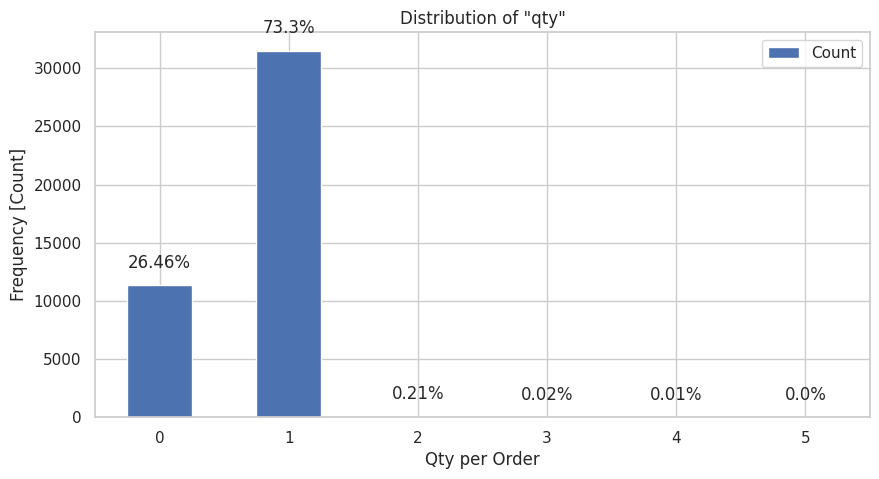

In [ ]:
# Analyzing Feature "qty": Quantity per Order

def analyze_qty_distribution(dataframe):
    """
    Analyzes and plots the distribution of the 'qty' feature.

    Parameters:
    dataframe (DataFrame): The dataframe containing the 'qty' column.
    """
    qty_distribution = dataframe["qty"].value_counts(normalize=True).sort_index()
    qty_distribution_df = qty_distribution.to_frame("Proportion")
    qty_distribution_df["Proportion"] = (qty_distribution_df["Proportion"] * 100).round(2).astype(str) + '%'
    qty_distribution_df["Count"] = dataframe["qty"].value_counts()

    qty_distribution_df.plot(kind="bar", y="Count", figsize=(10, 5))
    plt.xlabel("Qty per Order")
    plt.ylabel("Frequency [Count]")
    plt.title('Distribution of "qty"')
    plt.xticks(rotation=0)

    for index, value in qty_distribution_df["Proportion"].items():
        plt.text(index, qty_distribution_df.loc[index, "Count"] + 1500, value, ha='center')

    plt.show()

analyze_qty_distribution(df)

# Drop 'qty' feature
df.drop(columns="qty", inplace=True)


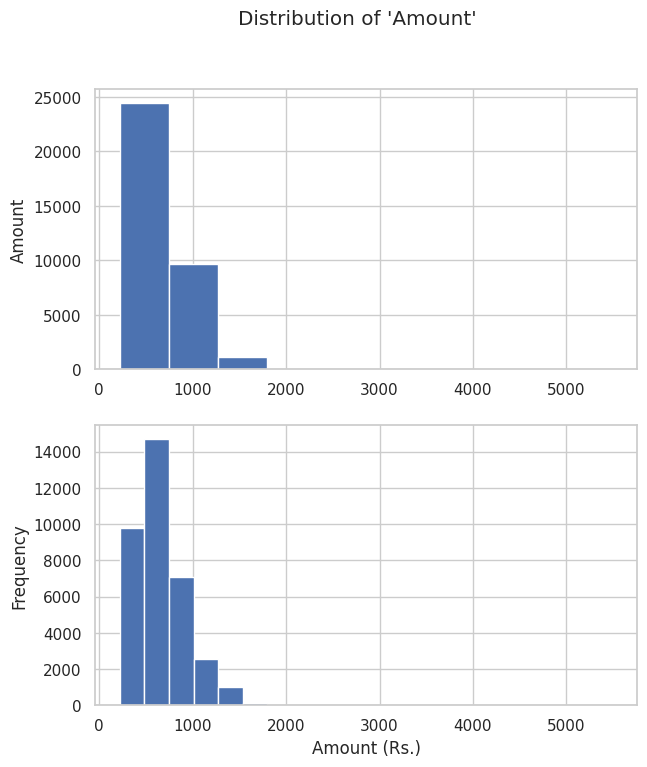

In [ ]:
# Analyzing Feature "amount": Amount in Rupees

def analyze_amount_feature(dataframe):
    """
    Analyzes the 'amount' feature, identifying and replacing zero values with NaN.

    Parameters:
    dataframe (DataFrame): Original dataframe.

    Returns:
    DataFrame: Modified dataframe.
    """
    # Replace 0s with NaN
    dataframe["amount"] = dataframe["amount"].replace(0, np.nan)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8))
    plt.suptitle("Distribution of 'Amount'")
    dataframe["amount"].plot(kind="hist",  ax=ax1)
    dataframe["amount"].plot(kind="hist", bins=20, ax=ax2)
    ax1.set_ylabel("Amount")
    ax2.set_ylabel("Frequency")
    ax2.set_xlabel("Amount (Rs.)")

    plt.show()

    return dataframe

df = analyze_amount_feature(df)

# Removing outliers (Top 5%)
df = df[(df["amount"] < df["amount"].quantile(0.95)) | df["amount"].isnull()]


In [ ]:
# Analyzing Other Categorical Features


def analyze_and_plot_categorical_distribution(dataframe, feature_name):
    """
    Analyzes a categorical feature and plots its distribution.

    Parameters:
    dataframe (DataFrame): The dataframe containing the feature.
    feature_name (str): The name of the feature to analyze.
    """
    # Calculate the counts and proportions of each category
    category_counts = dataframe[feature_name].value_counts()
    category_proportions = (category_counts / category_counts.sum() * 100).round(2)

    # Create a DataFrame for plotting
    plot_data = pd.DataFrame({
        'Count': category_counts,
        'Proportion (%)': category_proportions
    }).reset_index().rename(columns={'index': feature_name})

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_data.plot(kind='bar', x=feature_name, y='Count', ax=ax)

    ax.set_xlabel(feature_name.capitalize())
    ax.set_ylabel("Count")
    ax.set_title(f'Distribution of {feature_name.capitalize()}')

    # Adding proportion data labels
    for index, row in plot_data.iterrows():
        ax.text(index, row['Count'], f"{row['Proportion (%)']}%", ha='center', va='bottom', rotation=80,fontsize=10)

    plt.xticks(rotation=80, fontsize=10)
    plt.tight_layout()
    plt.show()




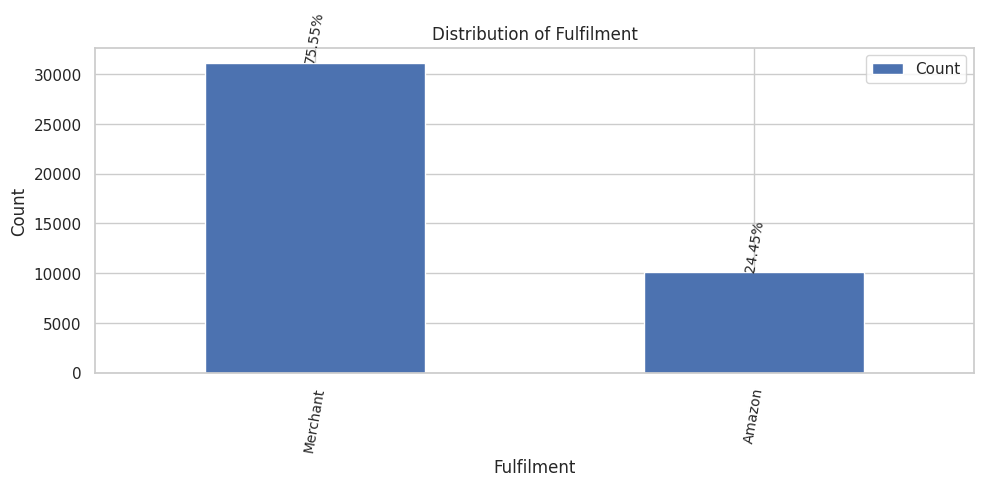

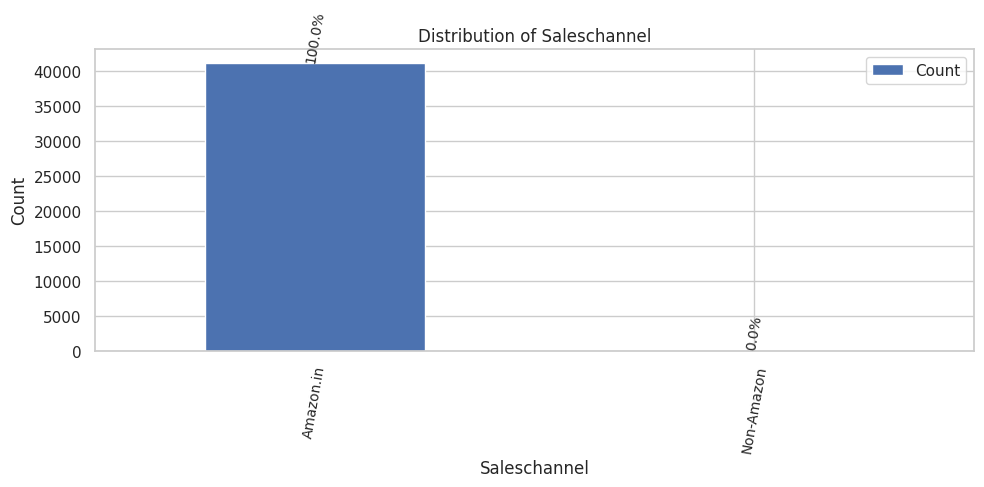

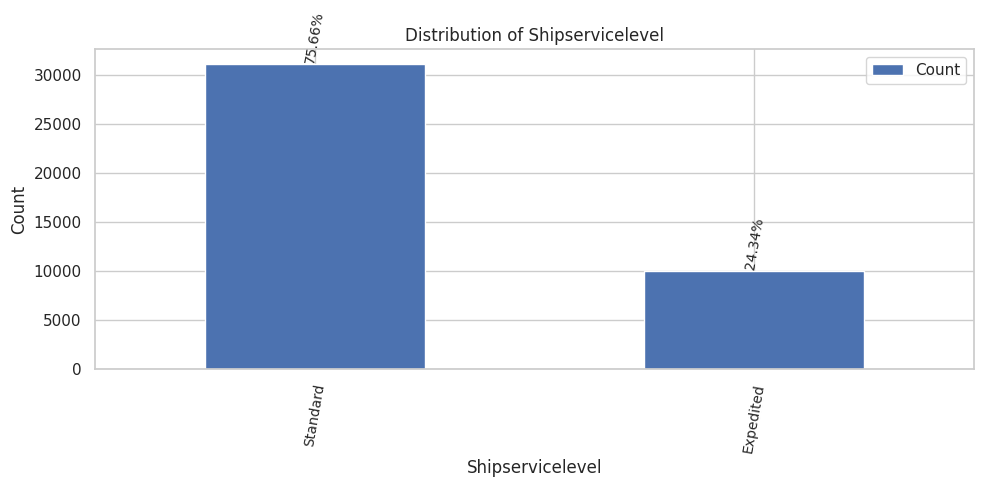

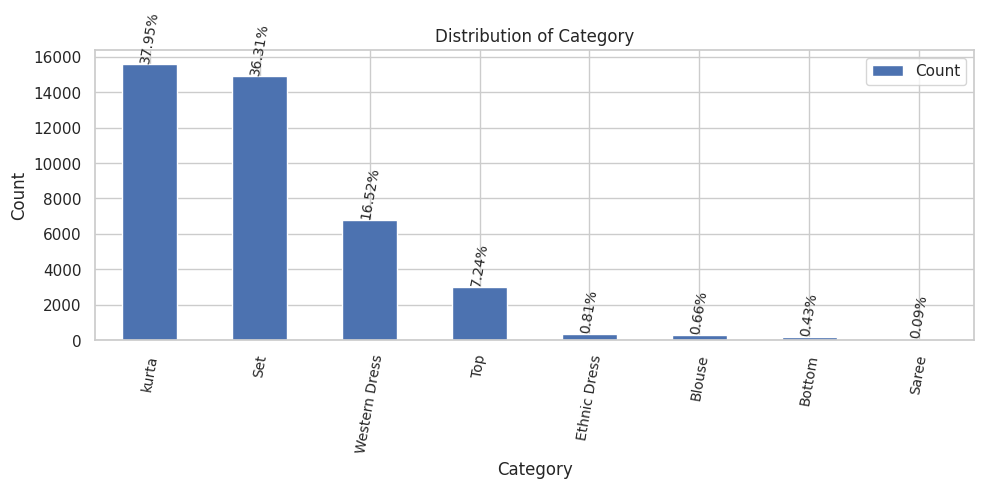

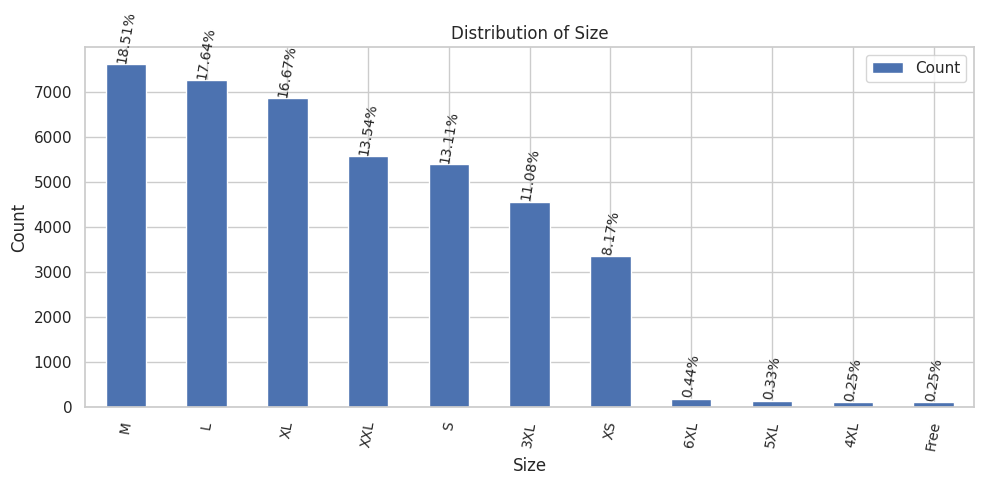

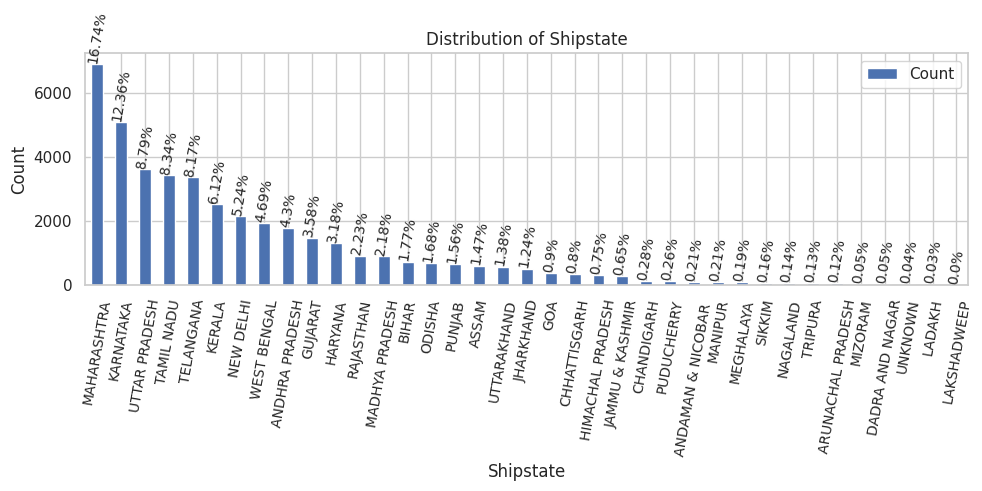

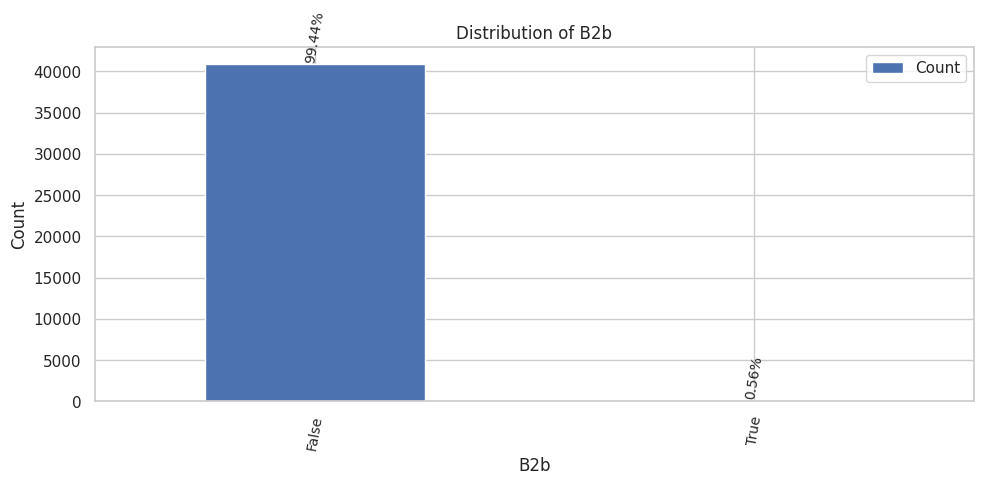

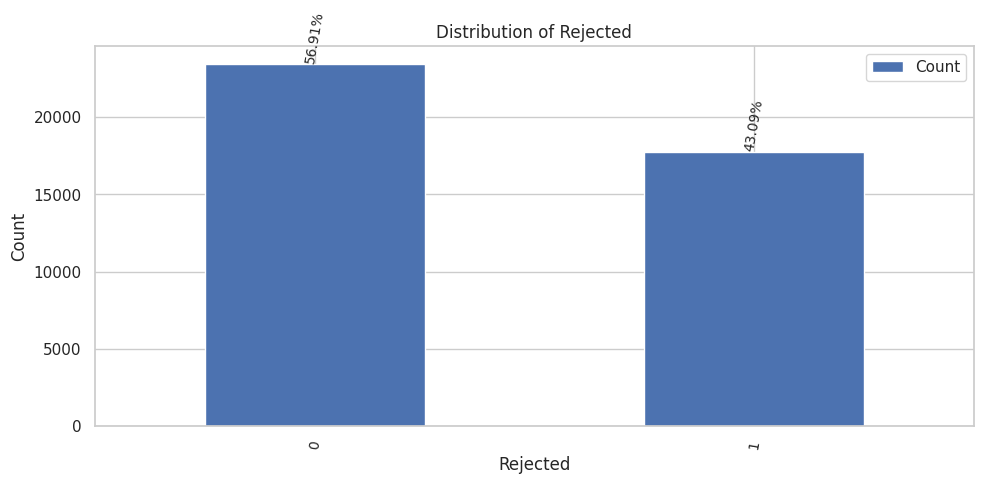

In [ ]:
for col in df.drop(['amount'], axis=1).columns:
  analyze_and_plot_categorical_distribution(df, col)
  print('\n\n\n\n')

### Bivariate Analysis

<Figure size 1000x600 with 0 Axes>

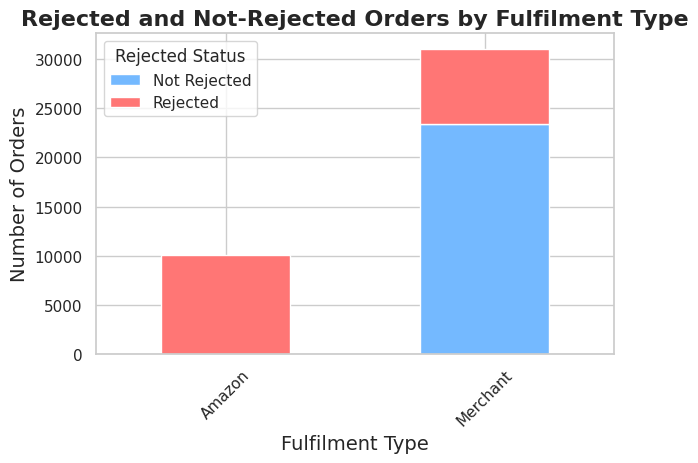

In [ ]:
# Calculate the count of rejected and not-rejected for each fulfilment type
fulfilment_rejected_counts = df.groupby(['fulfilment', 'rejected']).size().unstack(fill_value=0)

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
fulfilment_rejected_counts.plot(kind='bar', stacked=True, color=['#74b9ff', '#ff7675'])

# Customization
plt.title('Rejected and Not-Rejected Orders by Fulfilment Type', fontsize=16, fontweight='bold')
plt.xlabel('Fulfilment Type', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Rejected Status', labels=['Not Rejected', 'Rejected'])

plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

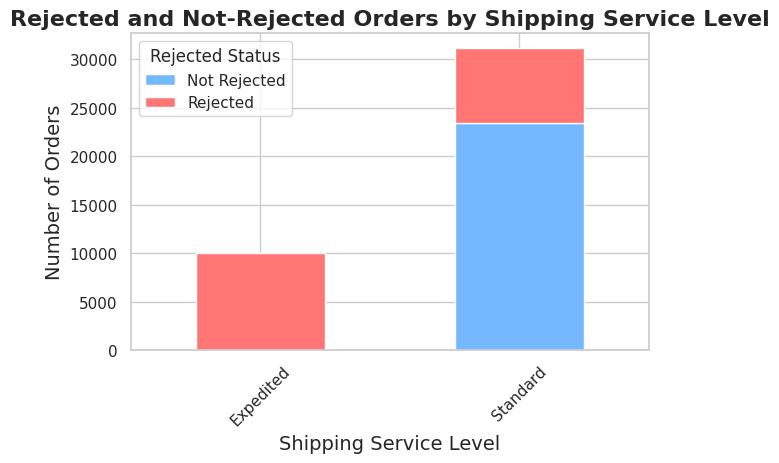

In [ ]:
# Calculate the count of rejected and not-rejected for each shipping service level
servicelevel_rejected_counts = df.groupby(['shipservicelevel', 'rejected']).size().unstack(fill_value=0)

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
servicelevel_rejected_counts.plot(kind='bar', stacked=True, color=['#74b9ff', '#ff7675'])

# Customization
plt.title('Rejected and Not-Rejected Orders by Shipping Service Level', fontsize=16, fontweight='bold')
plt.xlabel('Shipping Service Level', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Rejected Status', labels=['Not Rejected', 'Rejected'])

plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

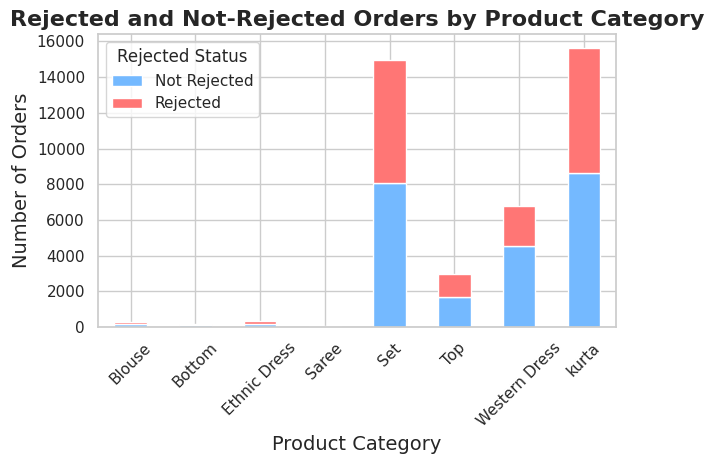

In [ ]:

# Calculate the count of rejected and not-rejected for each category
category_rejected_counts = df.groupby(['category', 'rejected']).size().unstack(fill_value=0)

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
category_rejected_counts.plot(kind='bar', stacked=True, color=['#74b9ff', '#ff7675'])

# Customization
plt.title('Rejected and Not-Rejected Orders by Product Category', fontsize=16, fontweight='bold')
plt.xlabel('Product Category', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Rejected Status', labels=['Not Rejected', 'Rejected'])

plt.tight_layout()
plt.show()


### Multivariate Analysis

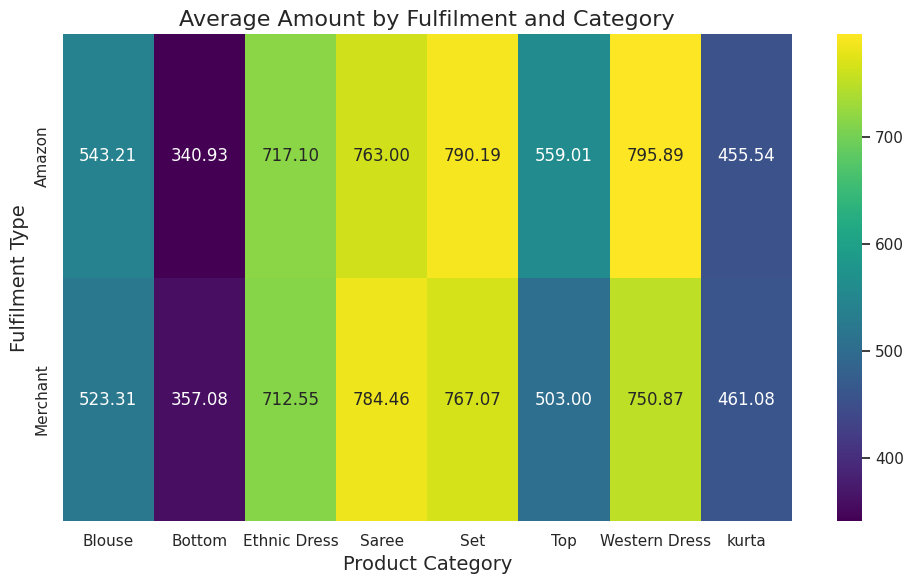

In [ ]:
# Creating a pivot table
pivot_table = df.pivot_table(values='amount', index='fulfilment', columns='category', aggfunc=np.mean)

# Plotting heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='viridis')

# Customization
plt.title('Average Amount by Fulfilment and Category', fontsize=16)
plt.ylabel('Fulfilment Type', fontsize=14)
plt.xlabel('Product Category', fontsize=14)

plt.tight_layout()
plt.show()


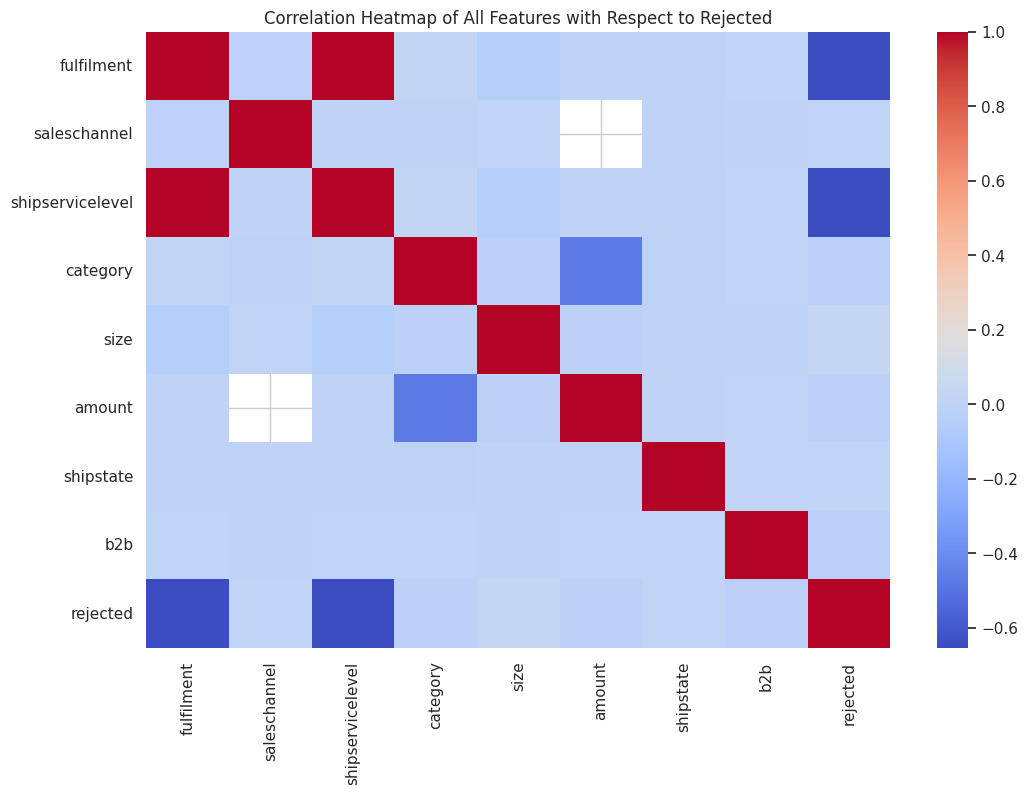

In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column
dfx = df.copy()
for col in df.select_dtypes(include=['object', 'bool']).columns:
    dfx[col] = label_encoder.fit_transform(df[col])

# Calculate the correlation matrix
corr_matrix = dfx.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Heatmap of All Features with Respect to Rejected')
plt.show()


## Data Preprocessing and Preparation for Modelling

In [ ]:
df.head()

,fulfilment,saleschannel,shipservicelevel,category,size,amount,shipstate,b2b,rejected
0,Merchant,Amazon.in,Standard,Set,S,647.62,MAHARASHTRA,False,1
1,Merchant,Amazon.in,Standard,kurta,3XL,406.00,KARNATAKA,False,0
3,Merchant,Amazon.in,Standard,Western Dress,L,753.33,PUDUCHERRY,False,1
7,Merchant,Amazon.in,Standard,kurta,S,399.00,TELANGANA,False,0
8,Amazon,Amazon.in,Expedited,Set,3XL,NaN,TELANGANA,False,1


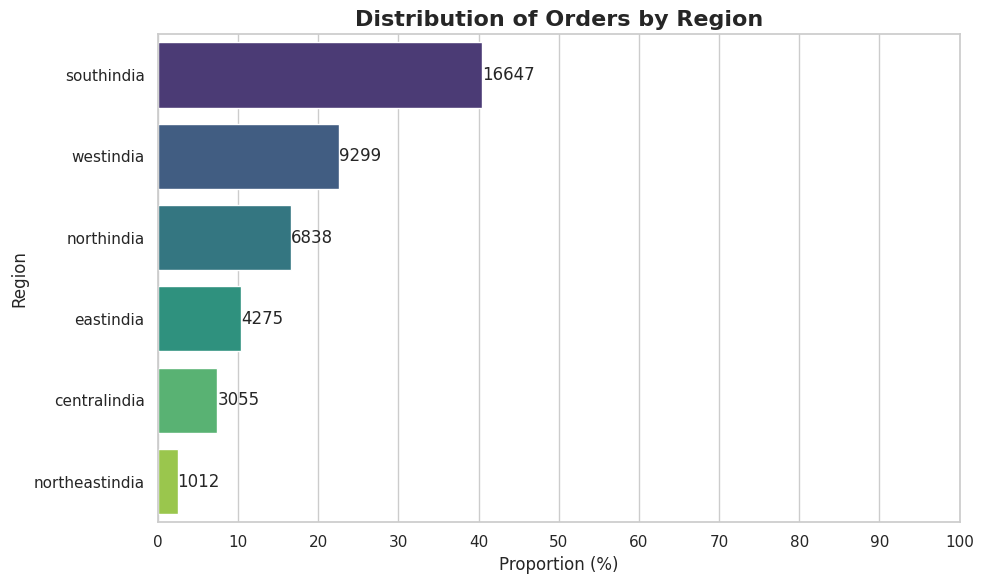

In [ ]:
# Mapping states to regions
state_to_region = {
    "MAHARASHTRA":"westindia","KARNATAKA":"southindia",
    'PUDUCHERRY':"southindia",'TELANGANA':"southindia",
    'ANDHRA PRADESH':"southindia", 'HARYANA':"northindia",
    'JHARKHAND':"eastindia", 'CHHATTISGARH':"eastindia",
    'ASSAM':"northeastindia",'ODISHA':"eastindia",
    'UTTAR PRADESH':"northindia", 'GUJARAT':"westindia",
    'TAMIL NADU':"southindia", 'UTTARAKHAND':"northindia",
    'WEST BENGAL':"eastindia", 'RAJASTHAN':"westindia",
    'NEW DELHI':"centralindia",'MADHYA PRADESH':"centralindia",
    'KERALA':"southindia", 'JAMMU & KASHMIR':"northindia",
    'BIHAR':"eastindia",'MEGHALAYA':"northeastindia",
    'PUNJAB':"northindia", 'GOA':"southindia",
    'TRIPURA':"northeastindia", 'CHANDIGARH':"northindia",
    'HIMACHAL PRADESH':"northindia",'SIKKIM':"northeastindia",
    "ANDAMAN & NICOBAR ":"eastindia", 'MANIPUR':"northeastindia",
    'MIZORAM':"northeastindia",'NAGALAND':"northeastindia",
    'ARUNACHAL PRADESH':"northeastindia", 'LADAKH':"northindia",
    'DADRA AND NAGAR':"westindia",'LAKSHADWEEP':"southindia"
}
df['region'] = df['shipstate'].map(state_to_region)

# Filter out rows with 'UNKNOWN' shipstate
df = df[df['region'] != 'unknown']

# Calculate the proportion of each region
region_counts = df['region'].value_counts()
region_proportions = round((region_counts / region_counts.sum()) * 100, 2)
region_data = pd.DataFrame({'Count': region_counts, 'Proportion (%)': region_proportions}).reset_index().rename(columns={'index': 'Region'})

# Sorting by proportion for better visualization
region_data.sort_values(by='Proportion (%)', ascending=False, inplace=True)

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Proportion (%)', y='Region', data=region_data, palette='viridis')

# Adding count annotations
for index, row in region_data.iterrows():
    plt.text(row['Proportion (%)'], index, f"{row['Count']}", va='center')

# Customization
plt.title('Distribution of Orders by Region', fontsize=16, fontweight='bold')
plt.xlabel('Proportion (%)')
plt.ylabel('Region')
plt.xticks(range(0, 101, 10))

plt.tight_layout()
plt.show()


In [ ]:
# drop saleschannel, b2b, shipstate

df.drop(['shipstate', 'saleschannel', 'b2b'], axis = 1, inplace = True)

df.head()

,fulfilment,shipservicelevel,category,size,amount,rejected,region
0,Merchant,Standard,Set,S,647.62,1,westindia
1,Merchant,Standard,kurta,3XL,406.00,0,southindia
3,Merchant,Standard,Western Dress,L,753.33,1,southindia
7,Merchant,Standard,kurta,S,399.00,0,southindia
8,Amazon,Expedited,Set,3XL,NaN,1,southindia


In [ ]:
df.fillna(df.mean(), inplace=True)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41126 entries, 0 to 128969
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fulfilment        41126 non-null  object 
 1   shipservicelevel  41126 non-null  object 
 2   category          41126 non-null  object 
 3   size              41126 non-null  object 
 4   amount            41126 non-null  float64
 5   rejected          41126 non-null  int64  
 6   region            41126 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 2.5+ MB


## Modelling

In [ ]:

# Split dataset
features, target = df.drop('rejected', axis=1), df['rejected']

# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

# Identifying column types
categorical_cols = features.select_dtypes(include=['object', 'bool']).columns
numerical_cols = features.select_dtypes(include=['int64', 'float64']).columns

# Column Transformer Pipeline
pipeline_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(), categorical_cols),
    ('scaler', StandardScaler(), numerical_cols)
])

# List of Classifiers
classifiers = [
    LogisticRegression(max_iter=70, solver='sag', random_state=42),
    DecisionTreeClassifier(max_depth=2, random_state=42),
    SVC(C=2, kernel='linear', random_state=42),
    RandomForestClassifier(max_depth=7, min_samples_split=5, random_state=42),
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=42), random_state=42),
    GradientBoostingClassifier(learning_rate=0.005, n_estimators=30, random_state=42),
    KNeighborsClassifier(),
    GaussianNB(var_smoothing=1e-2)
]

classifier_names = [
    'Logistic Regression', 'Decision Tree', 'SVM', 'Random Forest',
    'AdaBoost', 'Gradient Boosting', 'KNN', 'Gaussian Naive Bayes'
]

# Creating Pipelines
model_pipelines = []
for clf in classifiers:
    pipeline_steps = [('transformer', pipeline_transformer)]
    if isinstance(clf, GaussianNB):
        pipeline_steps.append(('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)))
    pipeline_steps.append(('classifier', clf))
    model_pipelines.append(Pipeline(pipeline_steps))

# Cross-validation settings
kfold = StratifiedKFold(n_splits=5)

# Perform cross-validation and store results
cv_results = {}
for name, pipeline in zip(classifier_names, model_pipelines):
    result = cross_validate(pipeline, X_train, y_train, cv=kfold, scoring='accuracy')
    cv_results[name] = result['test_score']




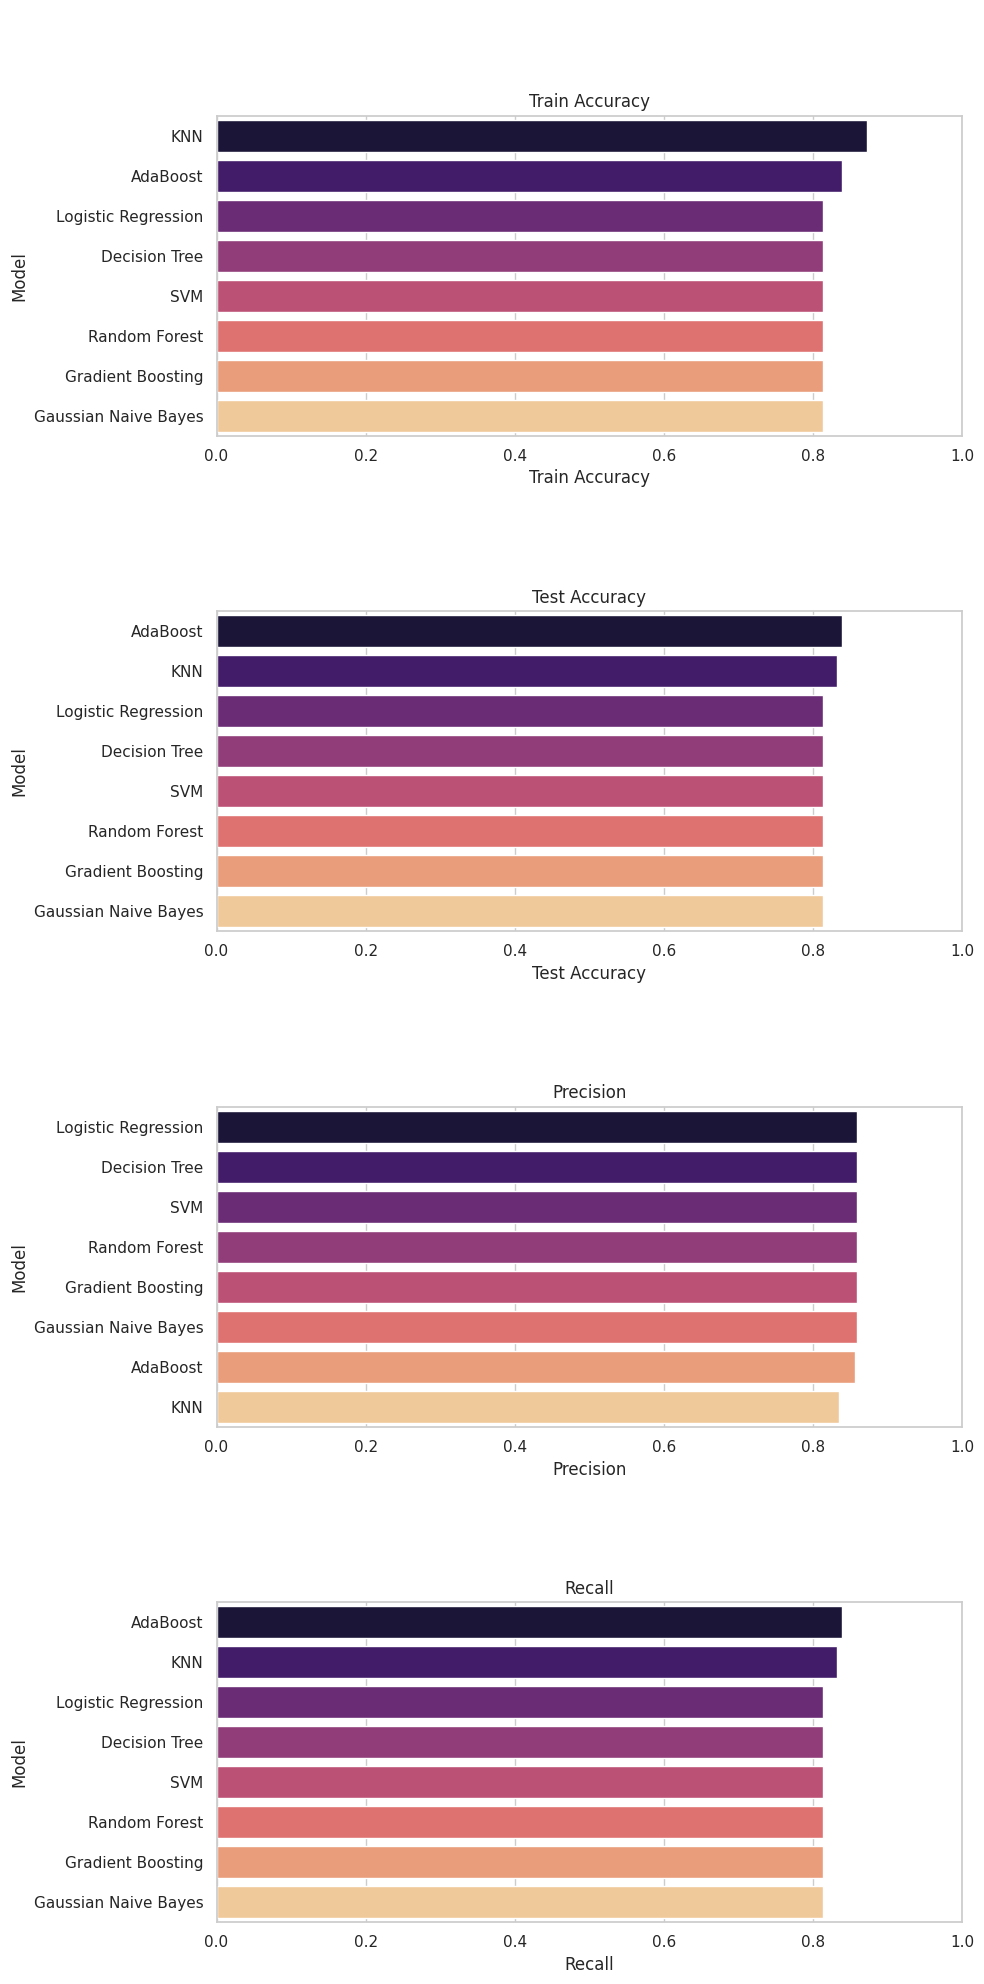

In [ ]:
# Function to compute test metrics
def compute_test_metrics(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    return accuracy, precision, recall

# Compute train and test metrics for each classifier
metrics_results = {'Model': classifier_names}
train_acc_list, test_acc_list, precision_list, recall_list = [], [], [], []

for name, pipeline in zip(classifier_names, model_pipelines):
    pipeline.fit(X_train, y_train)  # Fit the model
    train_acc = pipeline.score(X_train, y_train)
    test_acc, precision, recall = compute_test_metrics(pipeline, X_test, y_test)

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    precision_list.append(precision)
    recall_list.append(recall)

metrics_results['Train Accuracy'] = train_acc_list
metrics_results['Test Accuracy'] = test_acc_list
metrics_results['Precision'] = precision_list
metrics_results['Recall'] = recall_list

metrics_df = pd.DataFrame(metrics_results)

# Sort by Test Accuracy
metrics_df.sort_values(by='Test Accuracy', ascending=False, inplace=True)


# Plotting Function for Metrics with Individual Sorting
def plot_sorted_metrics(df):
    metrics = ['Train Accuracy', 'Test Accuracy', 'Precision', 'Recall']
    _, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 20))

    for i, metric in enumerate(metrics):
        sorted_df = df.sort_values(by=metric, ascending=False)
        sns.barplot(x=metric, y='Model', data=sorted_df, ax=axes[i], palette='magma')
        axes[i].set_xlim(0, 1)  # Assuming metric values are between 0 and 1
        axes[i].set_title('\n\n\n\n'+metric)


    plt.tight_layout()
    plt.show()

plot_sorted_metrics(metrics_df)

In [ ]:
metrics_df

,Model,Train Accuracy,Test Accuracy,Precision,Recall
4,AdaBoost,0.839547,0.839039,0.856817,0.839039
6,KNN,0.872585,0.833009,0.835663,0.833009
0,Logistic Regression,0.813513,0.813849,0.859846,0.813849
1,Decision Tree,0.813513,0.813849,0.859846,0.813849
2,SVM,0.813513,0.813849,0.859846,0.813849
3,Random Forest,0.813513,0.813849,0.859846,0.813849
5,Gradient Boosting,0.813513,0.813849,0.859846,0.813849
7,Gaussian Naive Bayes,0.813513,0.813849,0.859846,0.813849


## Now, AdaBoost Classifier

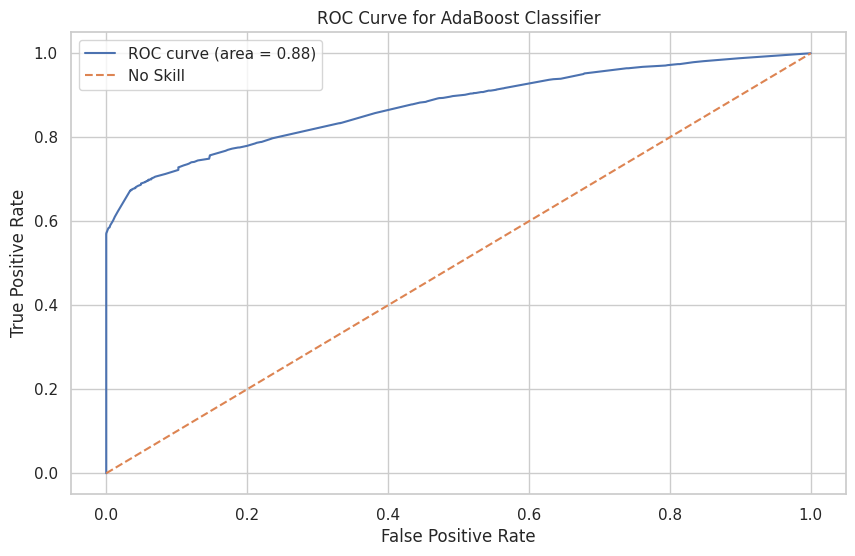

Accuracy: 0.84
Precision: 0.94
Recall: 0.67
ROC AUC Score: 0.88


In [ ]:
# Split dataset
X, y = df.drop('rejected', axis=1), df['rejected']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# Preprocessing: Encoding categorical columns and scaling numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(), categorical_cols),
    ('scaler', StandardScaler(), numerical_cols)
])



# Apply transformations
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Train the AdaBoost model
ada_boost_model = AdaBoostClassifier(random_state=42)
ada_boost_model.fit(X_train_transformed, y_train)

# Predict on the test set
y_pred = ada_boost_model.predict(X_test_transformed)
y_pred_proba = ada_boost_model.predict_proba(X_test_transformed)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC Curve
plt.figure(figsize=(10, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.title('ROC Curve for AdaBoost Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")


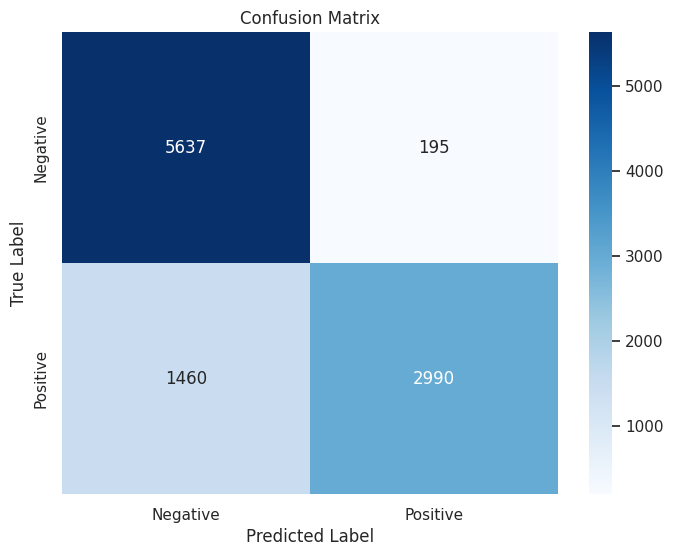

In [ ]:
# Calculate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# Get the classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.79      0.97      0.87      5832
           1       0.94      0.67      0.78      4450

    accuracy                           0.84     10282
   macro avg       0.87      0.82      0.83     10282
weighted avg       0.86      0.84      0.83     10282



### Model Optimization

In [ ]:
# Define the base estimator for AdaBoost
base_estimator = DecisionTreeClassifier(max_depth=1)

# Create the AdaBoost model pipeline with preprocessing
ada_boost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(base_estimator=base_estimator))
])

# Define a parameter grid to search over
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 1],
    'classifier__base_estimator__max_depth': [1, 2, 3]
}

# Create GridSearchCV
grid_search = GridSearchCV(ada_boost_pipeline, param_grid=param_grid, scoring='accuracy', cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best AdaBoost parameters found
best_params = grid_search.best_params_

# Train the best AdaBoost model
best_ada_boost = grid_search.best_estimator_

# Evaluate the best AdaBoost model
best_ada_boost.fit(X_train, y_train)
y_pred = best_ada_boost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Best parameters found: {best_params}')
print(f'Best AdaBoost model accuracy: {accuracy}')

Best parameters found: {'classifier__base_estimator__max_depth': 3, 'classifier__learning_rate': 1, 'classifier__n_estimators': 200}
Best AdaBoost model accuracy: 0.9246255592297219


In [ ]:
# Generating the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      5832
           1       0.94      0.88      0.91      4450

    accuracy                           0.92     10282
   macro avg       0.93      0.92      0.92     10282
weighted avg       0.93      0.92      0.92     10282



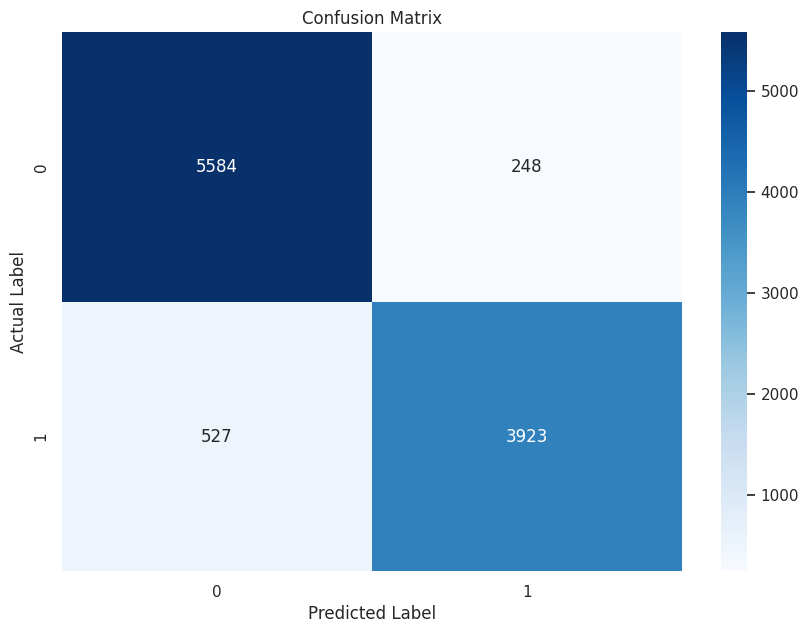

In [ ]:
# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Save model

joblib.dump(best_ada_boost, 'ada_boost_model.pkl')

['ada_boost_model.pkl']

In [ ]:
X_test.head()

,fulfilment,shipservicelevel,category,size,amount,region
65780,Merchant,Standard,Western Dress,3XL,721.000000,westindia
87918,Merchant,Standard,Western Dress,L,724.000000,westindia
26852,Amazon,Expedited,kurta,XXL,627.569818,eastindia
52956,Amazon,Expedited,Set,XXL,627.569818,centralindia
43854,Merchant,Standard,Set,3XL,791.000000,westindia


In [ ]:
import joblib

# Load the model
model = joblib.load('ada_boost_model.pkl')


In [ ]:
X_test.iloc[[0]]

,fulfilment,shipservicelevel,category,size,amount,region
65780,Merchant,Standard,Western Dress,3XL,721.0,westindia


In [ ]:
model.predict(X_test.iloc[[0]])[0]

0